# COVID-19 

This is my new version of analyses of COVID-19.  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np
import pandas as pd
import datetime
import time

# Canada

In [2]:
from src.phac import PHAC

can = PHAC()
as_of = "2020-05-09"

## Total Cases

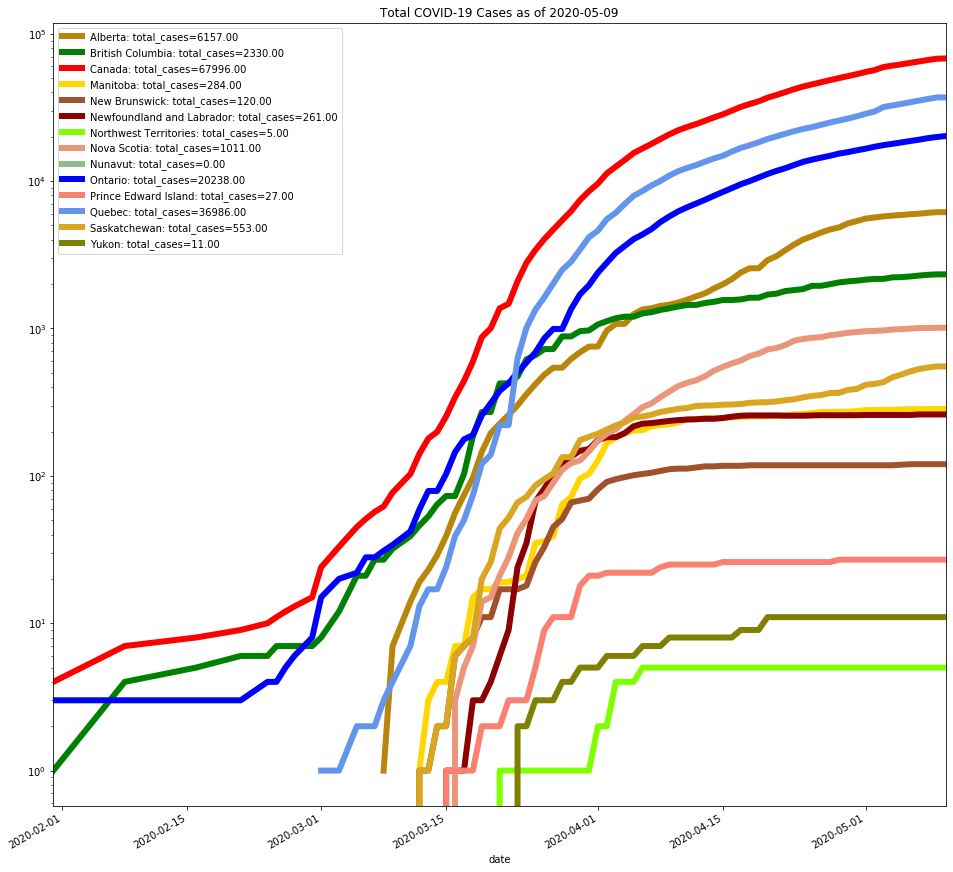

In [3]:
can_tc_fig = can.plot_var("total_cases", *can.provinces,
    figsize=(16,16),
    log_scale=True,
    colours=can.prov_colours,
    #date_start="2020-03-01",
    lw=6,
    title=f"Total COVID-19 Cases as of {as_of}"  
)


plt.show()

In [4]:
var_pivot = can.var_by_location("total_cases", *can.provinces)
var_pivot[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-05-04,60772.0,259.0,27.0,985.0,118.0,32623.0,17923.0,281.0,467.0,5836.0,2224.0,11.0,5.0,0.0
2020-05-05,62046.0,259.0,27.0,991.0,119.0,33417.0,18310.0,282.0,487.0,5893.0,2232.0,11.0,5.0,0.0
2020-05-06,63496.0,259.0,27.0,998.0,120.0,34327.0,18722.0,284.0,512.0,5963.0,2255.0,11.0,5.0,0.0
2020-05-07,64922.0,261.0,27.0,1007.0,120.0,35238.0,19121.0,283.0,531.0,6017.0,2288.0,11.0,5.0,0.0
2020-05-08,66434.0,261.0,27.0,1008.0,120.0,36150.0,19598.0,284.0,544.0,6098.0,2315.0,11.0,5.0,0.0
2020-05-09,67702.0,261.0,27.0,1011.0,120.0,36986.0,19944.0,284.0,553.0,6157.0,2330.0,11.0,5.0,0.0
2020-05-10,67996.0,261.0,27.0,1011.0,120.0,36986.0,20238.0,284.0,553.0,6157.0,2330.0,11.0,5.0,0.0


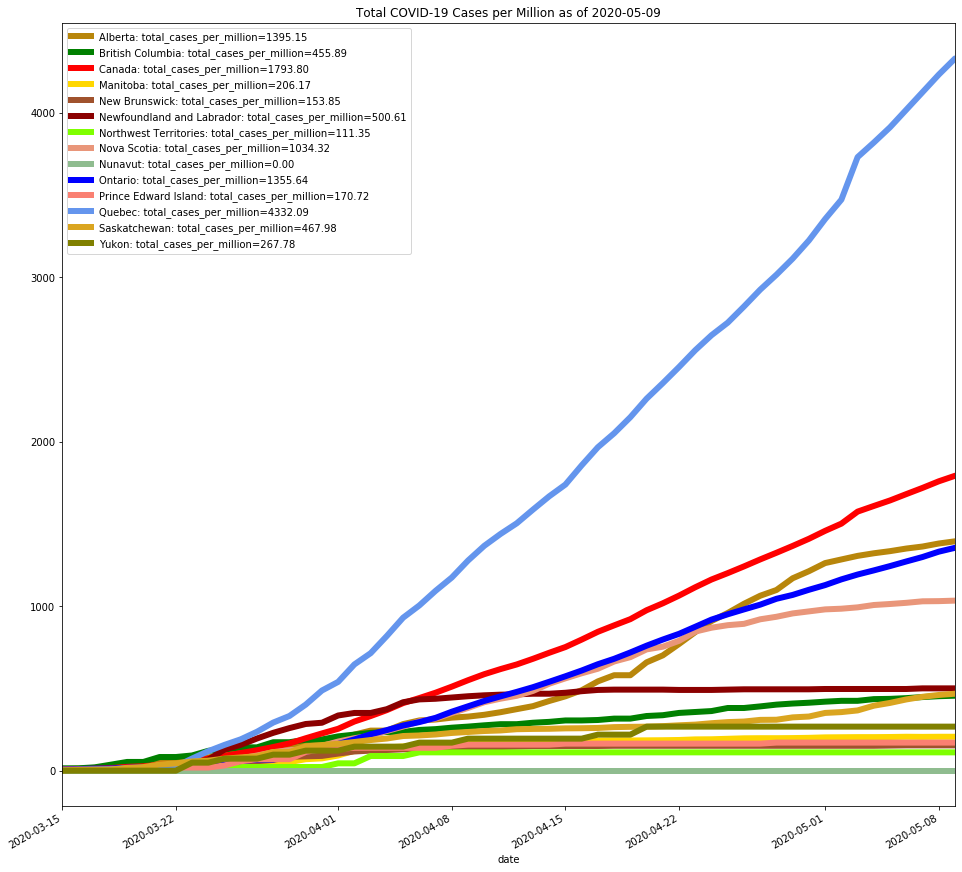

In [5]:
can_tcpm_fig = can.plot_var("total_cases_per_million", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-15",
    date_end=as_of,
    lw=6,
    title=f"Total COVID-19 Cases per Million as of {as_of}"  
)


plt.show()

## New cases

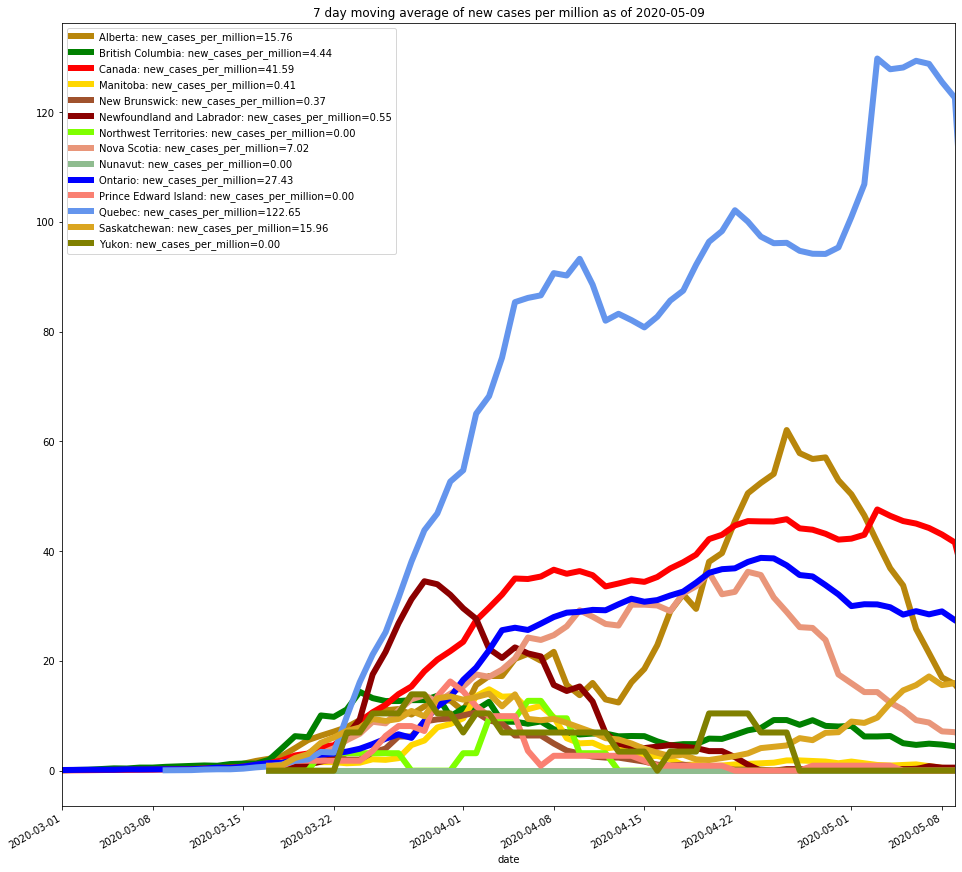

In [13]:
ma_win = 7
can_nc_fig = can.plot_var("new_cases_per_million", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)


plt.show()

In [7]:
can_nc = can.var_by_location("new_cases", *can.provinces)
can_nc["2020-05-02":"2020-05-09"][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-05-02,1653.0,0.0,0.0,4.0,0.0,1008.0,511.0,1.0,6.0,97.0,26.0,0.0,0.0,0.0
2020-05-03,2760.0,0.0,0.0,8.0,0.0,2209.0,434.0,1.0,12.0,96.0,0.0,0.0,0.0,0.0
2020-05-04,1298.0,0.0,0.0,14.0,0.0,758.0,370.0,0.0,34.0,70.0,53.0,0.0,0.0,0.0
2020-05-05,1274.0,0.0,0.0,6.0,1.0,794.0,387.0,1.0,20.0,57.0,8.0,0.0,0.0,0.0
2020-05-06,1450.0,0.0,0.0,7.0,1.0,910.0,412.0,2.0,25.0,70.0,23.0,0.0,0.0,0.0
2020-05-07,1426.0,2.0,0.0,9.0,0.0,911.0,399.0,-1.0,19.0,54.0,33.0,0.0,0.0,0.0
2020-05-08,1512.0,0.0,0.0,1.0,0.0,912.0,477.0,1.0,13.0,81.0,27.0,0.0,0.0,0.0
2020-05-09,1268.0,0.0,0.0,3.0,0.0,836.0,346.0,0.0,9.0,59.0,15.0,0.0,0.0,0.0


## Tests

In [ ]:
ma_win = 7

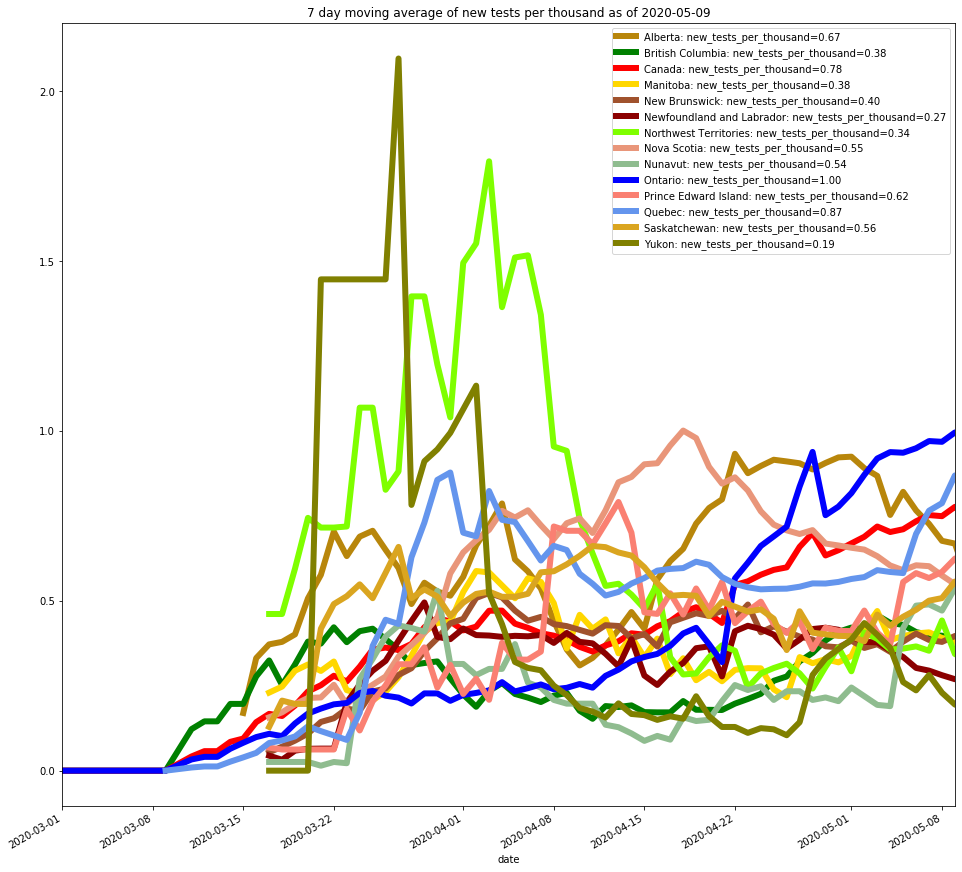

In [16]:

can_nt_fig = can.plot_var("new_tests_per_thousand", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new tests per thousand as of {as_of}"  
)


plt.show()

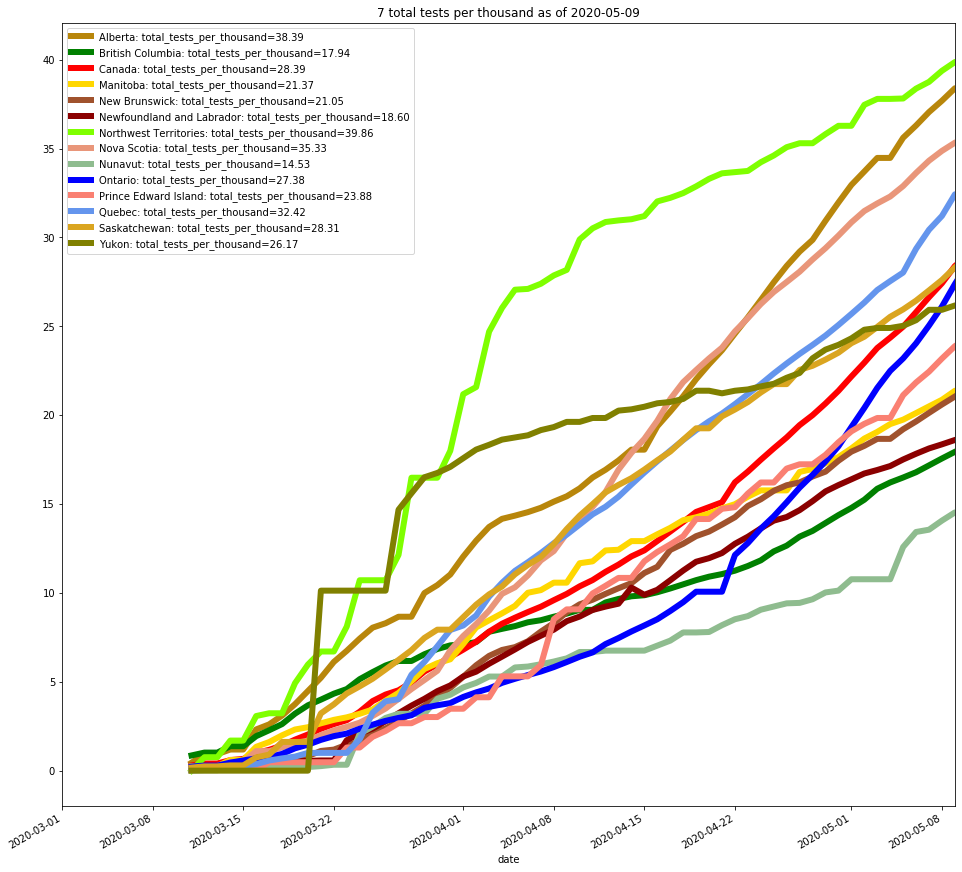

In [17]:
can_tt_fig = can.plot_var("total_tests_per_thousand", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} total tests per thousand as of {as_of}"  
)


plt.show()